## Load Dependencies

In [1]:
import pandas as pd
import numpy as np 
import pickle
import xgboost as xgb
import time
import matplotlib as plt
import re
import datetime

In [2]:
print('pandas version '+pd.__version__)
print('numpy version '+np.__version__)
print('xgboost version '+xgb.__version__)
print('matplotlib version '+plt.__version__)
print('re version '+re.__version__)

pandas version 0.23.4
numpy version 1.15.4
xgboost version 0.80
matplotlib version 3.0.2
re version 2.2.1


## Set Global Variables

In [3]:
START_NOTEBOOK = time.time()
LOAD_MODEL=False
WRITE_FILE=False
AVE= False

## Load Data

In [4]:
x_train , x_test , y_train , y_test = pickle.load(open('saved_datasets/19-3-19,pipeline_A_reduced_frommaster,dateback=18/xtrain_xtest_ytrain_ytest.pickle','rb'))

## Preprocessing

### Try averaging some features

A descision was made not to use this

In [ ]:
def ave_feats(df):
    feats = [     
     'sum_item_sales_back_',
     'sum_shop_sales_back_',
     'item_cnt_month_back_',
     'sum_item_cat_sales_back_',
     'sum_city_back_',
     'sum_itemtype_back_',
     'sum_iteminfo_back_'
            ]
    df = df.copy()
    for feat in feats:
        print('averaging on '+feat+'...')
        for i in np.arange(1,18,3):
            df['ave_'+feat+str(i)] = (df[feat+str(i)]+df[feat+str(i+1)]+df[feat+str(i+2)])/3
        reduced_cols = [a for a in df.columns.tolist() if not re.match('^'+feat,a)]
        df = df[reduced_cols]
    return df

In [6]:
if AVE:
    x_train = list(map(ave_feats,x_train))
    x_test = list(map(ave_feats,x_test))

### Try culling early data

Perhaps there is data so old, that we shouldn't use it?

In [7]:
x_train_saved = x_train
y_train_saved = y_train
x_train = []
y_train = []
CUTOFF = 0
for xtrain_el , ytrain_el in zip(x_train_saved,y_train_saved):
    x_train.append(xtrain_el[xtrain_el.date_block_num>CUTOFF])
    y_train.append(ytrain_el[xtrain_el.date_block_num>CUTOFF])

### Other Preproc

More Preprocessing, clipping the target and droping columns used for processing

In [8]:
def preproc_model3(x_train,x_test,y_train,y_test):

    x_train = [d.drop(['shop_id','item_id','item_category_id','city','item_type','item_info','month'],axis=1) for d in x_train]
    x_test =  [d.drop(['shop_id','item_id','item_category_id','city','item_type','item_info','month'],axis=1) for d in x_test]
    y_train = [d.clip(0,20) for d in y_train]
    y_test =  [d.clip(0,20) for d in y_test]
    return [x_train,x_test,y_train,y_test]

In [9]:
x_train , x_test , y_train , y_test = preproc_model3(x_train,x_test,y_train,y_test)

# Feature Selection

In [10]:
#x_train[0].columns.tolist()

In [11]:
feat_list= []
#feat_list = ['_'+str(x)+'$' for x in range(7,19)] + []
#feat_list = ['iteminfo','item_cat','city','item_sales']
feat_list

[]

In [12]:
def quickdrop(df):
    cols_keep = df.columns.tolist()
    for feat in feat_list:
        cols_keep = [c for c in cols_keep if not re.match('.*'+feat,c)]
    return df[cols_keep]

In [13]:
x_train = list(map(quickdrop,x_train))
x_test = list(map(quickdrop,x_test))

In [14]:
#x_train[0].columns.tolist()

### Select Validation/Test

In [15]:
PHASE='VAL'

In [16]:
if PHASE=='VAL':
    xtrain = x_train[0]
    ytrain = y_train[0]
    xtest = x_test[0]
    ytest = y_test[0]
    eval_set = [(xtrain,ytrain),(xtest,ytest)]
elif PHASE=='TEST':
    xtrain = x_train[1]
    ytrain = y_train[1]
    xtest = x_test[1]
    ytest = y_test[1]
    eval_set = [(xtrain,ytrain)]

## Fitting

In [17]:
model = xgb.XGBRegressor(
    seed=0,
    max_depth=2,
    learning_rate=0.05,
    n_estimators=50000,
#    n_estimators=59,
    objective='reg:linear',
    nthread=7,
    #min_child_weight=5000,
    colsample_bytree=1,
    subsample=1
)


In [18]:
if LOAD_MODEL:
    model = pickle.load(open('model.pickle','rb'))

In [19]:
if not LOAD_MODEL:
    model.fit(
        verbose=True,
        X=xtrain,
        y=ytrain,
        eval_set=eval_set,
        early_stopping_rounds=500
    )

[0]	validation_0-rmse:1.19352	validation_1-rmse:1.09797
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 500 rounds.
[1]	validation_0-rmse:1.17575	validation_1-rmse:1.08227
[2]	validation_0-rmse:1.15935	validation_1-rmse:1.06787
[3]	validation_0-rmse:1.14426	validation_1-rmse:1.05495
[4]	validation_0-rmse:1.13018	validation_1-rmse:1.04301
[5]	validation_0-rmse:1.11709	validation_1-rmse:1.03187
[6]	validation_0-rmse:1.10513	validation_1-rmse:1.0217
[7]	validation_0-rmse:1.0941	validation_1-rmse:1.01289
[8]	validation_0-rmse:1.08389	validation_1-rmse:1.00415
[9]	validation_0-rmse:1.07452	validation_1-rmse:0.996516
[10]	validation_0-rmse:1.06565	validation_1-rmse:0.989223
[11]	validation_0-rmse:1.05762	validation_1-rmse:0.982556
[12]	validation_0-rmse:1.05004	validation_1-rmse:0.976478
[13]	validation_0-rmse:1.04313	validation_1-rmse:0.970862
[14]	validation_0-rmse:1.03665	validation_1-rmse:

[137]	validation_0-rmse:0.921671	validation_1-rmse:0.883616
[138]	validation_0-rmse:0.921569	validation_1-rmse:0.88359
[139]	validation_0-rmse:0.921467	validation_1-rmse:0.883576
[140]	validation_0-rmse:0.921383	validation_1-rmse:0.883547
[141]	validation_0-rmse:0.921292	validation_1-rmse:0.883546
[142]	validation_0-rmse:0.921206	validation_1-rmse:0.883517
[143]	validation_0-rmse:0.92104	validation_1-rmse:0.883591
[144]	validation_0-rmse:0.920945	validation_1-rmse:0.883623
[145]	validation_0-rmse:0.920861	validation_1-rmse:0.883639
[146]	validation_0-rmse:0.920779	validation_1-rmse:0.883637
[147]	validation_0-rmse:0.920702	validation_1-rmse:0.883605
[148]	validation_0-rmse:0.920622	validation_1-rmse:0.883535
[149]	validation_0-rmse:0.920535	validation_1-rmse:0.883511
[150]	validation_0-rmse:0.920449	validation_1-rmse:0.883549
[151]	validation_0-rmse:0.920287	validation_1-rmse:0.883449
[152]	validation_0-rmse:0.920207	validation_1-rmse:0.883437
[153]	validation_0-rmse:0.920056	validatio

[275]	validation_0-rmse:0.912881	validation_1-rmse:0.881049
[276]	validation_0-rmse:0.912809	validation_1-rmse:0.88099
[277]	validation_0-rmse:0.912767	validation_1-rmse:0.880965
[278]	validation_0-rmse:0.912693	validation_1-rmse:0.880846
[279]	validation_0-rmse:0.912641	validation_1-rmse:0.880839
[280]	validation_0-rmse:0.912604	validation_1-rmse:0.880899
[281]	validation_0-rmse:0.912574	validation_1-rmse:0.880886
[282]	validation_0-rmse:0.912537	validation_1-rmse:0.880884
[283]	validation_0-rmse:0.912498	validation_1-rmse:0.880876
[284]	validation_0-rmse:0.91246	validation_1-rmse:0.880874
[285]	validation_0-rmse:0.912393	validation_1-rmse:0.88086
[286]	validation_0-rmse:0.912368	validation_1-rmse:0.880853
[287]	validation_0-rmse:0.91232	validation_1-rmse:0.880855
[288]	validation_0-rmse:0.91227	validation_1-rmse:0.880869
[289]	validation_0-rmse:0.912251	validation_1-rmse:0.880874
[290]	validation_0-rmse:0.912214	validation_1-rmse:0.88094
[291]	validation_0-rmse:0.912162	validation_1-

[412]	validation_0-rmse:0.908218	validation_1-rmse:0.880188
[413]	validation_0-rmse:0.908192	validation_1-rmse:0.880158
[414]	validation_0-rmse:0.908183	validation_1-rmse:0.880158
[415]	validation_0-rmse:0.908159	validation_1-rmse:0.88016
[416]	validation_0-rmse:0.908132	validation_1-rmse:0.880084
[417]	validation_0-rmse:0.908114	validation_1-rmse:0.880082
[418]	validation_0-rmse:0.908095	validation_1-rmse:0.880081
[419]	validation_0-rmse:0.908059	validation_1-rmse:0.880082
[420]	validation_0-rmse:0.908013	validation_1-rmse:0.880039
[421]	validation_0-rmse:0.907996	validation_1-rmse:0.880038
[422]	validation_0-rmse:0.907977	validation_1-rmse:0.88002
[423]	validation_0-rmse:0.907937	validation_1-rmse:0.880021
[424]	validation_0-rmse:0.907881	validation_1-rmse:0.880015
[425]	validation_0-rmse:0.907851	validation_1-rmse:0.880027
[426]	validation_0-rmse:0.907829	validation_1-rmse:0.880027
[427]	validation_0-rmse:0.907805	validation_1-rmse:0.879998
[428]	validation_0-rmse:0.907773	validatio

[550]	validation_0-rmse:0.90476	validation_1-rmse:0.87939
[551]	validation_0-rmse:0.904754	validation_1-rmse:0.879385
[552]	validation_0-rmse:0.904714	validation_1-rmse:0.879386
[553]	validation_0-rmse:0.904688	validation_1-rmse:0.879435
[554]	validation_0-rmse:0.904672	validation_1-rmse:0.879424
[555]	validation_0-rmse:0.904644	validation_1-rmse:0.879369
[556]	validation_0-rmse:0.904621	validation_1-rmse:0.879369
[557]	validation_0-rmse:0.90456	validation_1-rmse:0.879377
[558]	validation_0-rmse:0.904537	validation_1-rmse:0.879359
[559]	validation_0-rmse:0.904522	validation_1-rmse:0.879359
[560]	validation_0-rmse:0.904513	validation_1-rmse:0.879352
[561]	validation_0-rmse:0.904496	validation_1-rmse:0.879377
[562]	validation_0-rmse:0.904459	validation_1-rmse:0.879349
[563]	validation_0-rmse:0.904407	validation_1-rmse:0.879382
[564]	validation_0-rmse:0.904373	validation_1-rmse:0.879378
[565]	validation_0-rmse:0.904351	validation_1-rmse:0.879383
[566]	validation_0-rmse:0.904332	validation

[687]	validation_0-rmse:0.901824	validation_1-rmse:0.878819
[688]	validation_0-rmse:0.901815	validation_1-rmse:0.87882
[689]	validation_0-rmse:0.901798	validation_1-rmse:0.878889
[690]	validation_0-rmse:0.901781	validation_1-rmse:0.87888
[691]	validation_0-rmse:0.90177	validation_1-rmse:0.878873
[692]	validation_0-rmse:0.901752	validation_1-rmse:0.878869
[693]	validation_0-rmse:0.901708	validation_1-rmse:0.878755
[694]	validation_0-rmse:0.901671	validation_1-rmse:0.878766
[695]	validation_0-rmse:0.901643	validation_1-rmse:0.878717
[696]	validation_0-rmse:0.901637	validation_1-rmse:0.878718
[697]	validation_0-rmse:0.901611	validation_1-rmse:0.878683
[698]	validation_0-rmse:0.901597	validation_1-rmse:0.87868
[699]	validation_0-rmse:0.901576	validation_1-rmse:0.878724
[700]	validation_0-rmse:0.901568	validation_1-rmse:0.878721
[701]	validation_0-rmse:0.901538	validation_1-rmse:0.878681
[702]	validation_0-rmse:0.901514	validation_1-rmse:0.878649
[703]	validation_0-rmse:0.901497	validation_

[824]	validation_0-rmse:0.898873	validation_1-rmse:0.878112
[825]	validation_0-rmse:0.898866	validation_1-rmse:0.878112
[826]	validation_0-rmse:0.898853	validation_1-rmse:0.878123
[827]	validation_0-rmse:0.898833	validation_1-rmse:0.878127
[828]	validation_0-rmse:0.898824	validation_1-rmse:0.878105
[829]	validation_0-rmse:0.8988	validation_1-rmse:0.878025
[830]	validation_0-rmse:0.898794	validation_1-rmse:0.878031
[831]	validation_0-rmse:0.898781	validation_1-rmse:0.878029
[832]	validation_0-rmse:0.898769	validation_1-rmse:0.878029
[833]	validation_0-rmse:0.898727	validation_1-rmse:0.877954
[834]	validation_0-rmse:0.8987	validation_1-rmse:0.877978
[835]	validation_0-rmse:0.898678	validation_1-rmse:0.877955
[836]	validation_0-rmse:0.898667	validation_1-rmse:0.877956
[837]	validation_0-rmse:0.898646	validation_1-rmse:0.877948
[838]	validation_0-rmse:0.898615	validation_1-rmse:0.877958
[839]	validation_0-rmse:0.898612	validation_1-rmse:0.877958
[840]	validation_0-rmse:0.898592	validation_

[962]	validation_0-rmse:0.896615	validation_1-rmse:0.877596
[963]	validation_0-rmse:0.896605	validation_1-rmse:0.877595
[964]	validation_0-rmse:0.896594	validation_1-rmse:0.877547
[965]	validation_0-rmse:0.896584	validation_1-rmse:0.877558
[966]	validation_0-rmse:0.896575	validation_1-rmse:0.877557
[967]	validation_0-rmse:0.89656	validation_1-rmse:0.877559
[968]	validation_0-rmse:0.896552	validation_1-rmse:0.877546
[969]	validation_0-rmse:0.896541	validation_1-rmse:0.87755
[970]	validation_0-rmse:0.89653	validation_1-rmse:0.877545
[971]	validation_0-rmse:0.896519	validation_1-rmse:0.877535
[972]	validation_0-rmse:0.896509	validation_1-rmse:0.87749
[973]	validation_0-rmse:0.896483	validation_1-rmse:0.877497
[974]	validation_0-rmse:0.896472	validation_1-rmse:0.877494
[975]	validation_0-rmse:0.896457	validation_1-rmse:0.877524
[976]	validation_0-rmse:0.896445	validation_1-rmse:0.87752
[977]	validation_0-rmse:0.896442	validation_1-rmse:0.87752
[978]	validation_0-rmse:0.896426	validation_1-

[1098]	validation_0-rmse:0.894526	validation_1-rmse:0.877313
[1099]	validation_0-rmse:0.894507	validation_1-rmse:0.877251
[1100]	validation_0-rmse:0.894473	validation_1-rmse:0.877289
[1101]	validation_0-rmse:0.894464	validation_1-rmse:0.877292
[1102]	validation_0-rmse:0.894456	validation_1-rmse:0.877292
[1103]	validation_0-rmse:0.894449	validation_1-rmse:0.877297
[1104]	validation_0-rmse:0.894436	validation_1-rmse:0.87733
[1105]	validation_0-rmse:0.894422	validation_1-rmse:0.877318
[1106]	validation_0-rmse:0.894393	validation_1-rmse:0.877323
[1107]	validation_0-rmse:0.894373	validation_1-rmse:0.877325
[1108]	validation_0-rmse:0.894368	validation_1-rmse:0.877325
[1109]	validation_0-rmse:0.894363	validation_1-rmse:0.877328
[1110]	validation_0-rmse:0.89435	validation_1-rmse:0.877326
[1111]	validation_0-rmse:0.894341	validation_1-rmse:0.877323
[1112]	validation_0-rmse:0.894315	validation_1-rmse:0.877328
[1113]	validation_0-rmse:0.8943	validation_1-rmse:0.877354
[1114]	validation_0-rmse:0.8

[1233]	validation_0-rmse:0.892414	validation_1-rmse:0.876729
[1234]	validation_0-rmse:0.89241	validation_1-rmse:0.876729
[1235]	validation_0-rmse:0.892406	validation_1-rmse:0.876729
[1236]	validation_0-rmse:0.892396	validation_1-rmse:0.876745
[1237]	validation_0-rmse:0.892388	validation_1-rmse:0.876737
[1238]	validation_0-rmse:0.892368	validation_1-rmse:0.8767
[1239]	validation_0-rmse:0.892355	validation_1-rmse:0.876692
[1240]	validation_0-rmse:0.892348	validation_1-rmse:0.876683
[1241]	validation_0-rmse:0.892341	validation_1-rmse:0.876681
[1242]	validation_0-rmse:0.892321	validation_1-rmse:0.876688
[1243]	validation_0-rmse:0.892313	validation_1-rmse:0.876676
[1244]	validation_0-rmse:0.892292	validation_1-rmse:0.876686
[1245]	validation_0-rmse:0.892267	validation_1-rmse:0.876632
[1246]	validation_0-rmse:0.892255	validation_1-rmse:0.876647
[1247]	validation_0-rmse:0.892236	validation_1-rmse:0.876603
[1248]	validation_0-rmse:0.892228	validation_1-rmse:0.876598
[1249]	validation_0-rmse:0.

[1368]	validation_0-rmse:0.890805	validation_1-rmse:0.876442
[1369]	validation_0-rmse:0.890799	validation_1-rmse:0.876441
[1370]	validation_0-rmse:0.890792	validation_1-rmse:0.876432
[1371]	validation_0-rmse:0.890786	validation_1-rmse:0.876439
[1372]	validation_0-rmse:0.890783	validation_1-rmse:0.876439
[1373]	validation_0-rmse:0.890776	validation_1-rmse:0.876443
[1374]	validation_0-rmse:0.890761	validation_1-rmse:0.876447
[1375]	validation_0-rmse:0.89076	validation_1-rmse:0.876447
[1376]	validation_0-rmse:0.890751	validation_1-rmse:0.876461
[1377]	validation_0-rmse:0.890729	validation_1-rmse:0.876407
[1378]	validation_0-rmse:0.890713	validation_1-rmse:0.876378
[1379]	validation_0-rmse:0.890693	validation_1-rmse:0.876364
[1380]	validation_0-rmse:0.890675	validation_1-rmse:0.876367
[1381]	validation_0-rmse:0.89067	validation_1-rmse:0.876363
[1382]	validation_0-rmse:0.89066	validation_1-rmse:0.876369
[1383]	validation_0-rmse:0.890649	validation_1-rmse:0.876399
[1384]	validation_0-rmse:0.

[1503]	validation_0-rmse:0.889364	validation_1-rmse:0.876239
[1504]	validation_0-rmse:0.889358	validation_1-rmse:0.87624
[1505]	validation_0-rmse:0.889349	validation_1-rmse:0.876228
[1506]	validation_0-rmse:0.889347	validation_1-rmse:0.876228
[1507]	validation_0-rmse:0.889335	validation_1-rmse:0.876243
[1508]	validation_0-rmse:0.88933	validation_1-rmse:0.876243
[1509]	validation_0-rmse:0.889323	validation_1-rmse:0.87624
[1510]	validation_0-rmse:0.8893	validation_1-rmse:0.876179
[1511]	validation_0-rmse:0.889294	validation_1-rmse:0.876179
[1512]	validation_0-rmse:0.889289	validation_1-rmse:0.876167
[1513]	validation_0-rmse:0.889277	validation_1-rmse:0.876168
[1514]	validation_0-rmse:0.88927	validation_1-rmse:0.876168
[1515]	validation_0-rmse:0.889262	validation_1-rmse:0.876158
[1516]	validation_0-rmse:0.889255	validation_1-rmse:0.876157
[1517]	validation_0-rmse:0.889251	validation_1-rmse:0.876157
[1518]	validation_0-rmse:0.889249	validation_1-rmse:0.876157
[1519]	validation_0-rmse:0.889

[1639]	validation_0-rmse:0.888169	validation_1-rmse:0.87595
[1640]	validation_0-rmse:0.888149	validation_1-rmse:0.875958
[1641]	validation_0-rmse:0.888144	validation_1-rmse:0.875958
[1642]	validation_0-rmse:0.888142	validation_1-rmse:0.875958
[1643]	validation_0-rmse:0.888137	validation_1-rmse:0.875955
[1644]	validation_0-rmse:0.888133	validation_1-rmse:0.87596
[1645]	validation_0-rmse:0.88813	validation_1-rmse:0.87596
[1646]	validation_0-rmse:0.888121	validation_1-rmse:0.875951
[1647]	validation_0-rmse:0.888108	validation_1-rmse:0.875962
[1648]	validation_0-rmse:0.8881	validation_1-rmse:0.875963
[1649]	validation_0-rmse:0.888094	validation_1-rmse:0.875961
[1650]	validation_0-rmse:0.888081	validation_1-rmse:0.87596
[1651]	validation_0-rmse:0.888076	validation_1-rmse:0.875949
[1652]	validation_0-rmse:0.888065	validation_1-rmse:0.875971
[1653]	validation_0-rmse:0.888059	validation_1-rmse:0.87597
[1654]	validation_0-rmse:0.888044	validation_1-rmse:0.875961
[1655]	validation_0-rmse:0.88801

[1774]	validation_0-rmse:0.886878	validation_1-rmse:0.875679
[1775]	validation_0-rmse:0.886874	validation_1-rmse:0.875678
[1776]	validation_0-rmse:0.886862	validation_1-rmse:0.875675
[1777]	validation_0-rmse:0.886851	validation_1-rmse:0.875534
[1778]	validation_0-rmse:0.886839	validation_1-rmse:0.875507
[1779]	validation_0-rmse:0.886833	validation_1-rmse:0.875507
[1780]	validation_0-rmse:0.88683	validation_1-rmse:0.875507
[1781]	validation_0-rmse:0.886826	validation_1-rmse:0.875506
[1782]	validation_0-rmse:0.886825	validation_1-rmse:0.875506
[1783]	validation_0-rmse:0.886812	validation_1-rmse:0.875526
[1784]	validation_0-rmse:0.886805	validation_1-rmse:0.875522
[1785]	validation_0-rmse:0.8868	validation_1-rmse:0.875519
[1786]	validation_0-rmse:0.886796	validation_1-rmse:0.875521
[1787]	validation_0-rmse:0.886791	validation_1-rmse:0.875521
[1788]	validation_0-rmse:0.886784	validation_1-rmse:0.875523
[1789]	validation_0-rmse:0.886776	validation_1-rmse:0.875526
[1790]	validation_0-rmse:0.

[1909]	validation_0-rmse:0.885725	validation_1-rmse:0.875358
[1910]	validation_0-rmse:0.885722	validation_1-rmse:0.875357
[1911]	validation_0-rmse:0.885711	validation_1-rmse:0.875371
[1912]	validation_0-rmse:0.885708	validation_1-rmse:0.875371
[1913]	validation_0-rmse:0.885702	validation_1-rmse:0.875369
[1914]	validation_0-rmse:0.885693	validation_1-rmse:0.875392
[1915]	validation_0-rmse:0.885666	validation_1-rmse:0.875388
[1916]	validation_0-rmse:0.88565	validation_1-rmse:0.875408
[1917]	validation_0-rmse:0.885634	validation_1-rmse:0.875417
[1918]	validation_0-rmse:0.885624	validation_1-rmse:0.875394
[1919]	validation_0-rmse:0.885615	validation_1-rmse:0.875275
[1920]	validation_0-rmse:0.885609	validation_1-rmse:0.875277
[1921]	validation_0-rmse:0.885598	validation_1-rmse:0.875247
[1922]	validation_0-rmse:0.885578	validation_1-rmse:0.875239
[1923]	validation_0-rmse:0.885568	validation_1-rmse:0.875216
[1924]	validation_0-rmse:0.885559	validation_1-rmse:0.875194
[1925]	validation_0-rmse:

[2044]	validation_0-rmse:0.884599	validation_1-rmse:0.875495
[2045]	validation_0-rmse:0.884591	validation_1-rmse:0.875501
[2046]	validation_0-rmse:0.884581	validation_1-rmse:0.875498
[2047]	validation_0-rmse:0.884573	validation_1-rmse:0.875497
[2048]	validation_0-rmse:0.884566	validation_1-rmse:0.875502
[2049]	validation_0-rmse:0.884563	validation_1-rmse:0.875503
[2050]	validation_0-rmse:0.884557	validation_1-rmse:0.8755
[2051]	validation_0-rmse:0.884553	validation_1-rmse:0.875499
[2052]	validation_0-rmse:0.884548	validation_1-rmse:0.875506
[2053]	validation_0-rmse:0.884536	validation_1-rmse:0.875505
[2054]	validation_0-rmse:0.884534	validation_1-rmse:0.875505
[2055]	validation_0-rmse:0.884525	validation_1-rmse:0.875495
[2056]	validation_0-rmse:0.884517	validation_1-rmse:0.875467
[2057]	validation_0-rmse:0.884504	validation_1-rmse:0.875471
[2058]	validation_0-rmse:0.884497	validation_1-rmse:0.875444
[2059]	validation_0-rmse:0.884474	validation_1-rmse:0.875444
[2060]	validation_0-rmse:0

[2179]	validation_0-rmse:0.883781	validation_1-rmse:0.875391
[2180]	validation_0-rmse:0.883774	validation_1-rmse:0.875374
[2181]	validation_0-rmse:0.883761	validation_1-rmse:0.875407
[2182]	validation_0-rmse:0.883754	validation_1-rmse:0.875397
[2183]	validation_0-rmse:0.883751	validation_1-rmse:0.875397
[2184]	validation_0-rmse:0.883747	validation_1-rmse:0.875395
[2185]	validation_0-rmse:0.883744	validation_1-rmse:0.875396
[2186]	validation_0-rmse:0.883736	validation_1-rmse:0.875367
[2187]	validation_0-rmse:0.883732	validation_1-rmse:0.875365
[2188]	validation_0-rmse:0.88372	validation_1-rmse:0.875364
[2189]	validation_0-rmse:0.883716	validation_1-rmse:0.875364
[2190]	validation_0-rmse:0.883713	validation_1-rmse:0.875364
[2191]	validation_0-rmse:0.883709	validation_1-rmse:0.875358
[2192]	validation_0-rmse:0.883703	validation_1-rmse:0.875365
[2193]	validation_0-rmse:0.8837	validation_1-rmse:0.875356
[2194]	validation_0-rmse:0.883696	validation_1-rmse:0.875359
[2195]	validation_0-rmse:0.

[2314]	validation_0-rmse:0.882848	validation_1-rmse:0.875251
[2315]	validation_0-rmse:0.882838	validation_1-rmse:0.875256
[2316]	validation_0-rmse:0.882835	validation_1-rmse:0.875256
[2317]	validation_0-rmse:0.882831	validation_1-rmse:0.875257
[2318]	validation_0-rmse:0.882826	validation_1-rmse:0.875259
[2319]	validation_0-rmse:0.882822	validation_1-rmse:0.875259
[2320]	validation_0-rmse:0.882816	validation_1-rmse:0.875252
[2321]	validation_0-rmse:0.882812	validation_1-rmse:0.875251
[2322]	validation_0-rmse:0.882808	validation_1-rmse:0.875251
[2323]	validation_0-rmse:0.882805	validation_1-rmse:0.875246
[2324]	validation_0-rmse:0.882801	validation_1-rmse:0.875244
[2325]	validation_0-rmse:0.882799	validation_1-rmse:0.875244
[2326]	validation_0-rmse:0.882796	validation_1-rmse:0.875247
[2327]	validation_0-rmse:0.882785	validation_1-rmse:0.875246
[2328]	validation_0-rmse:0.882782	validation_1-rmse:0.875246
[2329]	validation_0-rmse:0.882773	validation_1-rmse:0.87524
[2330]	validation_0-rmse:

In [20]:
print('CUTOFF='+str(CUTOFF))

CUTOFF=0


## Save Model

In [21]:
if not LOAD_MODEL:
    pickle.dump(model,open('model.pickle','wb'))

## Exploration

### Accuracy per tree in forrest

In [22]:
deval = model.evals_result()
val0 = deval['validation_0']['rmse']
val1 = deval['validation_1']['rmse']
deval = pd.DataFrame({'val0':val0,'val1':val1})

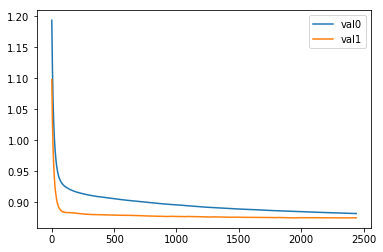

In [31]:
deval.plot()

### Gain

Gain is ...

In [24]:
gain = pd.Series(model.get_booster().get_score(importance_type='gain'))
gain = gain.sort_values(ascending=True)
type(gain)

pandas.core.series.Series

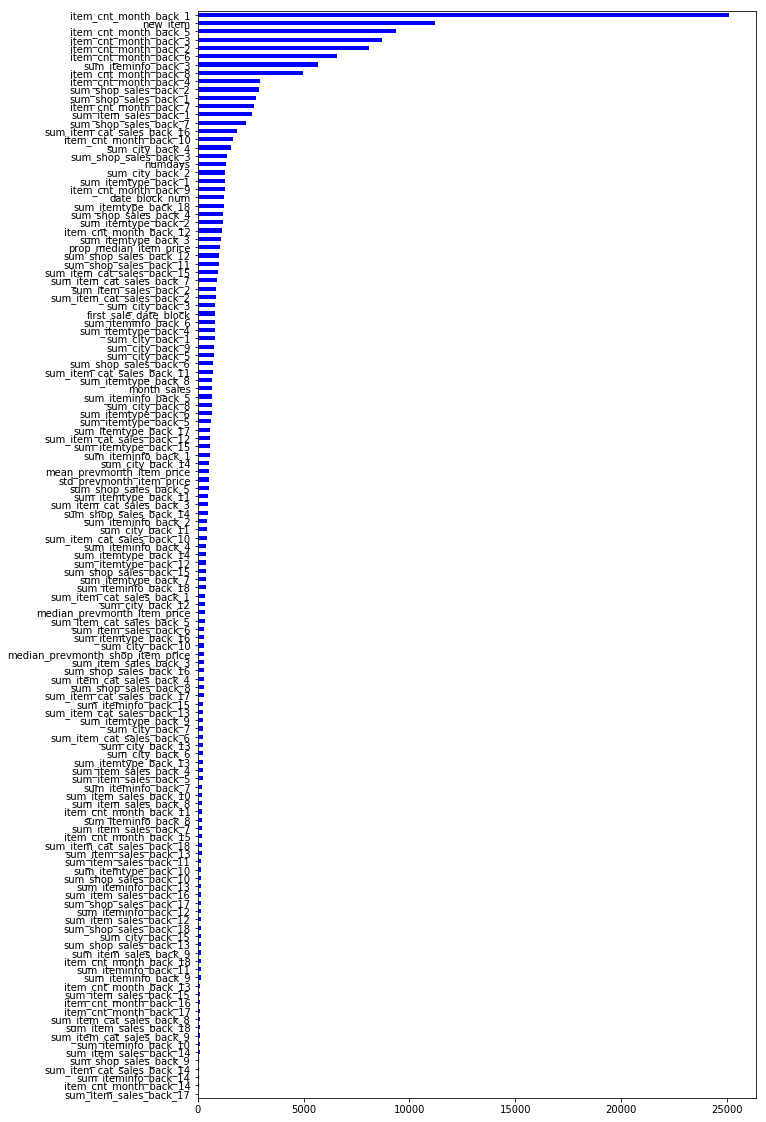

In [25]:
ax = gain.plot(kind='barh',color='b')
ax.figure.set_size_inches(10,20)

### Gain by time-indexed variable type

explain

In [26]:
#d = pd.DataFrame()
d = {}
coltypes=[  
 'sum_item_sales_back_',
 'sum_shop_sales_back_',
 'item_cnt_month_back_',
 'sum_item_cat_sales_back_',
 'sum_item_cat_shop_sales_back_',
 'sum_city_back_',
 'sum_itemtype_back_',
 'sum_iteminfo_back_',
 'sum_city_item_back_',
 'sum_city_item_cat_back_',
 'sum_itemtype_shop_back_',
 'sum_itemtype_city_back_']
save=[]
for ct in coltypes:
    save.append(gain.filter(regex=ct))
    d[ct] = np.sum(gain.filter(regex=ct))

In [27]:
sorted(d.items(),key=lambda t: t[1],reverse=True)

[('item_cnt_month_back_', 73575.12277127105),
 ('sum_shop_sales_back_', 15994.074340241454),
 ('sum_itemtype_back_', 11468.090188905413),
 ('sum_iteminfo_back_', 10471.631266545035),
 ('sum_city_back_', 9367.969235339886),
 ('sum_item_cat_sales_back_', 9075.65004166366),
 ('sum_item_sales_back_', 6414.694805201416),
 ('sum_item_cat_shop_sales_back_', 0.0),
 ('sum_city_item_back_', 0.0),
 ('sum_city_item_cat_back_', 0.0),
 ('sum_itemtype_shop_back_', 0.0),
 ('sum_itemtype_city_back_', 0.0)]

# Write Submissions

In [28]:
preds = model.predict(xtest)

## Submission 1

In [29]:
if WRITE_FILE:
    submission = pd.DataFrame({'ID':np.arange(0,214200),'item_cnt_month':preds})
    submission.to_csv('submissions/submission'+str(datetime.datetime.now()).replace(':','.')+'.csv',index=False)

## Submission 2, Adjusting for Leak

In [30]:
if WRITE_FILE:
    submission['item_cnt_month'] = 0.2839365/submission.item_cnt_month.mean() * submission.item_cnt_month
    submission.to_csv('submissions/submission_adjusted_'+str(datetime.datetime.now()).replace(':','.')+'.csv',index=False)